In [909]:
#math and linear algebra stuff
import numpy as np
#np.seterr(all='warn')
#import warnings
#warnings.filterwarnings('error')
import numpy.linalg as la

# Image manipulation and cv
import skimage.io
import skimage.filters
import skimage.transform

#plots
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Estimating ellipsoid from data

This notebook intends to presents a few simple ways to find the n-dimensional ellipsoid or the n-dimensional gaussian distribution that best fit a set of data points.

## Introduction : from balls to ellipsoid

Ellipsoid are funny mathematical objects, more precisely, they are geometrical constructions in euclidean spaces like $\mathbb{R}^n$ that are closely related to symmetric matrices and quadratic forms.

Most of people know about the concept of euclidean ball, or sphere, which can easily be extended in n-dimensions as $l_2$-ball or hypersphere, whose later definition is, in $ \mathbb{R}^n$:
$$
    x \in \mathbb{R}^n \; \text{ such that} \; \sqrt{ \sum_{i=0}^{n-1} x_i^2 } = r
$$
Where $r\geq 0$ is called the radius.<br>
We can recognize the definition of the $l_2$ norm in this expression, and directly write:
$$
    x \in \mathbb{R}^n \; \text{ such that} \; \|x\|_2 = r
$$

(-1.0, 1.0, -1.0, 1.0)

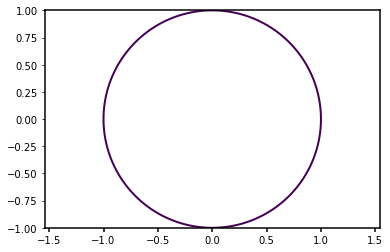

In [667]:
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)

#Let's draw a circle of equation \sqrt{X^2 + Y^2} -1 = 0
C = np.sqrt(X**2 + Y**2) - 1
plt.contour(X,Y,C,[0])
plt.axis('equal')

One can now generalize the concept of distance in euclidean space, through Hilbert spaces in finite dimension using specific definition of inner product.

For instance, we can rewrite the norm $\|\|_2$ as $\|\|_{M_I}$ where $M_I$ is the identity matrix of size $n\times n$:
$$
M_I =
\begin{pmatrix}
    1 & 0 & \dots & 0\\
    0 & 1 & \ddots & \vdots\\
    \vdots & \ddots & \ddots & 0 \\
    0 & \dots & 0 & 1
\end{pmatrix}
$$

Using this notation, $\|x\|_{M_I}$ can be computed as $\sqrt{x^{\intercal} M_I x}$

One can scale the diagonal elements of $M_I$ so that overall norm will grow faster for some coordinates, in this case, the corresponding ball will be more constrained in that direction, let's take a simple 2D example:

$$
M_{aniso} =
\begin{pmatrix}
    1 & 0\\
    0 & 4
\end{pmatrix}
$$

Which give the following ball equation:
\begin{align*}
    \sqrt{x^{\intercal} M_{aniso} x} = 1\\
    \sqrt{x_1^2 + 4 x_2^2} -1 = 0
\end{align*}

Where of course, the length of the semi-axis will be $\frac{1}{\sqrt{1}}=1$ along $x_1$ (when $x_2=0$) and $\frac{1}{\sqrt{4}}=\frac{1}{2}$ along $x_2$ (when $x_1 = 0$)

(-1.0, 1.0, -1.0, 1.0)

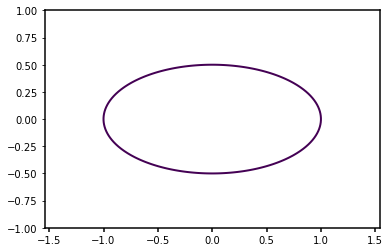

In [668]:
#Let's draw an axis aligned ellipsis of equation \sqrt{x^t Maniso x} -1 = 0

#Define Maniso, then linearize the meshgrid for matrix-vector product
Maniso = np.array([[1,0],[0,4]])
xvec = [np.reshape(X,X.size),np.reshape(Y,Y.size)]

#plot contour of \sqrt{x^t Maniso x} -1 = 0
test=np.dot(Maniso,xvec)
E=np.sqrt(np.sum(test*xvec,0))-1

plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')

## Positive semi-definite matrix
Nice, the ellipsis is indeed more constrained along the $y$ direction. But what about the $M$ matrix that defines the self dot poduct used in the norm calculation ? Can we choose it randomly ?

Of course not, $M$ should be positive semi definite (PSD), so that the square root can be applied to the result of $x^{\intercal}Mx \succeq 0$. Unfortunately, positive semi definite is a rather abstract definition for a matrix, some even call it a convex cone which is even more abstract.

There are numerous example of PSD matrices:
- symmetric dyads $uu^{\intercal}$, PSD is easily provable because $x^{\intercal}uu^{\intercal}x = (u^{\intercal}x)^2 \geq 0$
- self product of matrix $M^{\intercal}M$, PSD i given by $x^{\intercal}M^{\intercal}Mx = (Mx)^2 \geq 0$
- Covariance matrix
- Gram matrix
- Laplacian matrix of a graph, see the notebook about Spectral gaph theory
- ...

Although not all PSD matrices are symmetric, all matrices cited here are symmetric and PSD, and in general symmetric matrices are PSD, and can be diagonalized in an orthonormal basis, whose matrix is called orthonormal aka unitary, aka rotation matrix.

This last assertion (that can be easily proven TODO) is very important, because it means geometrically that every symmetric matrix, can be expressed as an axis aligned dilation in a given rotated basis.

See for instance this simple 2D example that uses the previous dilation, and a rotation matrix $M_{rot}$ by angle $\theta = \frac{\pi}{8}$ :
$$
M_{rot} =
\begin{pmatrix}
    cos(\theta) & -sin(\theta)\\
    sin(\theta) & cos(\theta)
\end{pmatrix}
$$
In order to generate a PSD of the form:
\begin{align*}
    M_{anisorot} &= M_{rot} M_{aniso} M_{rot}^{\intercal} \\
    &= \begin{pmatrix}
            cos(\theta) & -sin(\theta)\\
            sin(\theta) & cos(\theta)
        \end{pmatrix}
        \begin{pmatrix}
            1 & 0\\
            0 & 4
        \end{pmatrix}
        \begin{pmatrix}
            cos(\theta) & sin(\theta)\\
            -sin(\theta) & cos(\theta)
        \end{pmatrix}
\end{align*}

(-1.0, 1.0, -1.0, 1.0)

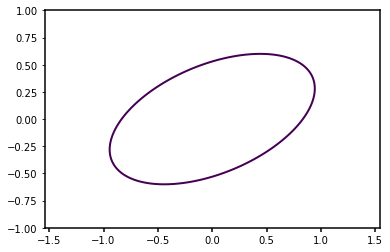

In [669]:
def get_manisorot(theta=np.pi/8., a=1, b=4):
    #define the rotation matrix:
    def GetRotMat( theta ):
        return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    Mrot = GetRotMat( theta )
    
    # Define anysotropy matrix
    Maniso = np.diag([a, b])
    
    #compute the rotation/dilation/inverse rotation matrix Manisorot = Mrot Maniso Mrot^t
    Manisorot = np.dot(Maniso,Mrot.T)
    Manisorot = np.dot(Mrot,Manisorot)
    return Manisorot
    
Manisorot = get_manisorot(theta=np.pi/8., a=1, b=4)

#plot contour of \sqrt{x^t Manisorot x} -1 = 0
test=np.dot(Manisorot,xvec)
E=np.sqrt(np.sum(test*xvec,0))-1

plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')

### Quadratic form

The matrix definition of an ellipsoid : $x^{\intercal}Mx$ can obviously be developped, and give a multivariate polynomial of degree 2 of the form
$$
\sum_{i=0, j=0}^{n-1, n-1} M_{ij} x_i x_j
$$

This sum has $n^2$ terms, but, as all $M_{ij}$ and $M_{ji}$ terms can be factorized, the underlying quadratic form actually has $\frac{n \times (n-1)}{2}$ terms. Unfortunately, we won't talk much about quadratic forms here.

More on quadratic forms in the notebook QuadraticFormsForFun

## Parametrizing ellipsoid in 2d
Although this is only valid in 2 dimensions, we thought it would be worth to mention that, when drawn in 2D, an ellipse can be described as a 1dimensional curve and expressed in 1d by parametrization.

Lets first consider
$$
M_{aniso} =
\begin{pmatrix}
    a & 0\\
    0 & b
\end{pmatrix}
$$

Which give the following ball equation:
\begin{align*}
    \sqrt{x^{\intercal} M_{aniso} x} = 1\\
    \sqrt{a x_1^2 + b x_2^2} -1 = 0
\end{align*}

The first solution, we won't describe in two much details here, simply consist in defining two curves:
\begin{align*}
    f_1(x_1) = -\sqrt{\frac{1-a x_1^2}{b}}
\end{align*}
and
\begin{align*}
    f_2(x_1) = \sqrt{\frac{1-a x_1^2}{b}}
\end{align*}
The non axis aligned or non origin centered case can be simply obtained by applying the rotation matrix then the translation.

Another possibility to parametrize an ellipsoid through a new variable $t$, is to use the following identity:

\begin{align*}
    cos(t)^2 + sin(t)^2 = 1
\end{align*}
And try to make it appear from our original expression by identifying $p_1$ and $p_2$ when replacing the original variables with:
\begin{align*}
    \begin{cases}
        x_1=p_1 \cos(t)\\
        x_2=p_2 \sin(t)
    \end{cases}
    \quad \text{with} \quad t \in[0,2\pi]
\end{align*}

Lets restart from:
\begin{align*}
    \sqrt{x^{\intercal} M_{aniso} x} = r\\
    \sqrt{a x_1^2 + b x_2^2} = r\\
    \Rightarrow a x_1^2 + b x_2^2 = r^2\\
    a x_1^2 + b x_2^2 = r^2\\
    \frac{a}{r^2} p_1^2 \cos(t)^2  + \frac{b}{r^2} p_2^2 \sin(t)^2 = 1\\
\end{align*}
one finds:
\begin{align*}
    \begin{cases}
        x_1=\frac{r}{\sqrt{a}} \cos(t)\\
        x_2=\frac{r}{\sqrt{b}} \sin(t)
    \end{cases}
    \text{with} \quad t \in[0,2\pi]
\end{align*}

Here again, the non axis aligned or non origin centered case can be simply obtained by applying the rotation matrix then the translation.

Lets see how it works in practice

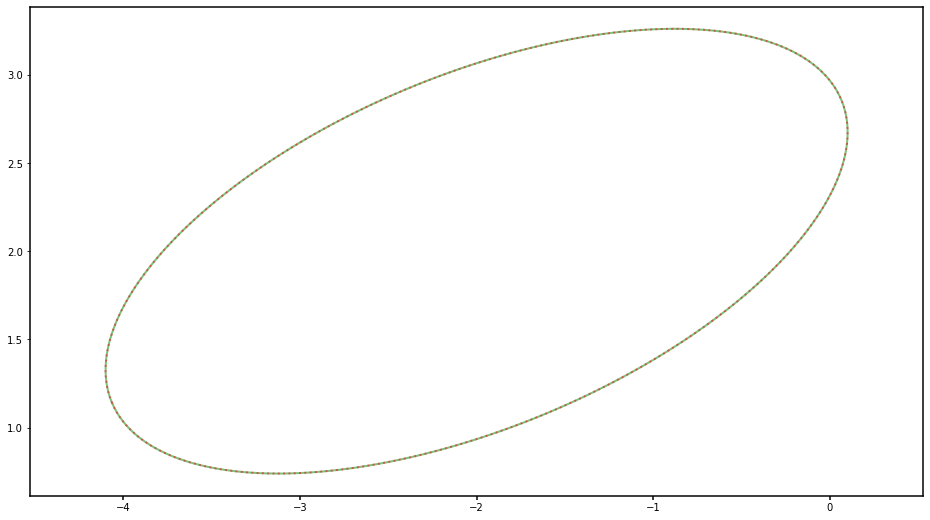

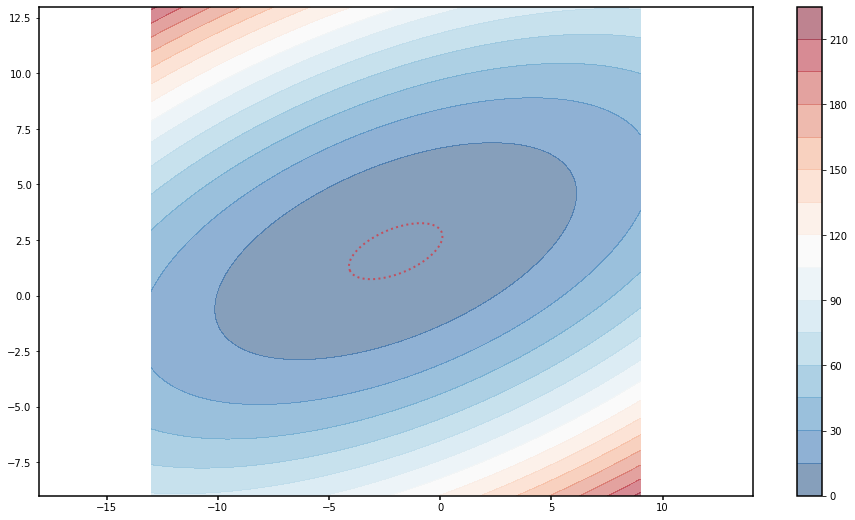

In [910]:
def get_ellipsoid_aabb(M,c=np.array([0,0]),r=1):
    #define a new grid
    e,v = la.eig(M)
    idx = e.argsort()[::-1] #sort values from highest to lowest

    #longest and shortest semi axis
    e=r/np.sqrt(e)
    a=e[idx[0]]
    b=e[idx[1]]

    #consider largest axe - associated with first eigenvalue
    angle = np.arctan2(v[1,idx[0]],v[0,idx[0]])

    #plot semi axes
    #plt.plot([c[0],c[0]+a*v[0,idx[0]]],[c[1],c[1]+a*v[1,idx[0]]], 'k-', lw=0.5)
    #plt.plot([c[0],c[0]+b*v[0,idx[1]]],[c[1],c[1]+b*v[1,idx[1]]], 'k-', lw=0.5)

    #Compute AABB - X
    maxT1=np.arctan(-(b/a)*np.tan(angle))
    maxT2=maxT1+np.pi
    val1=a*np.cos(angle)*np.cos(maxT1)-b*np.sin(angle)*np.sin(maxT1)
    val2=a*np.cos(angle)*np.cos(maxT2)-b*np.sin(angle)*np.sin(maxT2)
    minX = np.minimum(val1,val2)+c[0]
    maxX = np.maximum(val1,val2)+c[0]
    #Compute AABB - Y
    maxT1=np.arctan(b/(a*np.tan(angle)))
    maxT2=maxT1+np.pi
    val1=a*np.sin(angle)*np.cos(maxT1)+b*np.cos(angle)*np.sin(maxT1)
    val2=a*np.sin(angle)*np.cos(maxT2)+b*np.cos(angle)*np.sin(maxT2)
    minY = np.minimum(val1,val2)+c[1]
    maxY = np.maximum(val1,val2)+c[1]

    return minX, maxX, minY, maxY

#define parametrization
def get_ellipse_contour(M,c=np.array([0,0]),r=1,nb_points=512):
    #Find the Maniso
    e,v = la.eig(M)

    # semi axis
    e=r/np.sqrt(e)
    a=e[0]
    b=e[1]

    #Arbitrary consider vector associates with smallest axe - associated with largest eigenvalue
    t = np.linspace(0,2*np.pi, nb_points)
    xs = a*np.cos(t)
    ys = b*np.sin(t)
    
    rot = v
    # Apply  rotation to parametrized curve coordinates
    temp = np.dot(rot,np.stack((xs,ys)))
    #print(temp.shape)
    return temp[0,:]+c[0],temp[1,:]+c[1]

    
def draw_ellipse_contour(M,c=np.array([0,0]),r=None, fig=None, ax=None, method='parametrized', color='g'):
    """
        The equation for the ellipse given in "center form" is
        (x-c).T * M * (x-c) = r
    """

    #prepare plot
    if ax is None:
        fig, ax = plt.subplots(1,figsize=(16,9))
    
    if method == 'contour' or method == 'both':
        #plot contour of \sqrt{x^t Manisorot x} -r = 0
        try:
            minX, maxX, minY, maxY = get_ellipsoid_aabb(M,c,r)
        except:
            minX, maxX, minY, maxY = c[0]-10, c[0]+10, c[1]-10, c[1]+10
        marginX=0.05*(maxX-minX)
        marginY=0.05*(maxY-minY)
        x = np.linspace(minX-marginX, maxX+marginX, 100)
        y = np.linspace(minY-marginY, maxY+marginY, 100)
        X, Y = np.meshgrid(x,y)
        xvec = [np.reshape(X,X.size),np.reshape(Y,Y.size)]

        test=np.dot(M,xvec-c.reshape(-1,1))
        if r is not None:
            E=np.sqrt(np.sum(test*(xvec-c.reshape(-1,1)),0))-r
            #E=np.sum(test*(xvec-c.reshape(-1,1)),0)-r**2
            ax.contour(X,Y,np.reshape(E,X.shape),[0],colors=[color], alpha=0.5)
        else:
            E=np.sum(test*(xvec-c.reshape(-1,1)),0)
            #ax.contour(X,Y,np.reshape(E,X.shape),colors=[color], alpha=0.5)
            cntr = ax.tricontourf(X.flatten(),Y.flatten(),np.reshape(E,X.shape).flatten(), levels=14,
                                  cmap="RdBu_r", alpha=0.5)
            #import skimage.io as io
            #io.imsave('./test.tif', np.reshape(E,X.shape).reshape(X.shape).astype(np.float32))
            fig.colorbar(cntr, ax=ax)
    elif method == 'parametrized' or method == 'both':
        #Now plot parametric version
        xs,ys = get_ellipse_contour(M,c,r)
        ax.plot(xs, ys, color=color, alpha=0.5, linestyle='dotted')
    else:
        raise RuntimeError(f"Unknown tracing method {method}")
    ax.axis('equal')

Manisorot = get_manisorot(theta=1*np.pi/8., a=0.2, b=1)
fig, ax = plt.subplots(1,figsize=(16,9))
draw_ellipse_contour(Manisorot,c=np.array([-2,2]),r=1,fig=fig,ax=ax,method='contour', color='g')
draw_ellipse_contour(Manisorot,c=np.array([-2,2]),r=1,fig=fig,ax=ax,method='parametrized', color='r')

# In case no r is provided
fig, ax = plt.subplots(1,figsize=(16,9))
draw_ellipse_contour(Manisorot,c=np.array([-2,2]),r=1,fig=fig,ax=ax,method='parametrized', color='r')
draw_ellipse_contour(Manisorot,c=np.array([-2,2]),r=None,fig=fig,ax=ax,method='contour', color='r')

### Ellipsoid volume

When studying the determinant of a matrix, it is always interesting to see this scalar as the volume of the hyperparallelogram described by the column vector of this matrix.
Determinant somehow describes the volume dilation applied to the unitary hypercube (identity matrix) when multiplied by the matrix.

In the case of the Ellipsoid, the matrix coefficients, describes the force of the $l_2$ norm constraints, and it is actually the inverse of this matrix that caracterize the dilation behaviour.

The inherent volume dilation can then be computed as the determinant of the inverse of the ellipsoid matrix.

We can then write, for an ellipsoid of matrix $M$ in $\mathbb{R}^n$ its volume $V_M$ as the product of the volume of the unit ball in $\mathbb{R}^n$ times $det(M^{-1})$.
First, we recall that the volume $V^n(r)$ of the the $l_2$ ball in $\mathbb{R}^n$ is
$$
    V^n(r) =\frac{\pi^{n/2}r^{n}}{\Gamma \left({\frac{n}{2}}+1\right)}
$$
Which gives
$$
    V_M = \frac{\pi^{n/2}}{\Gamma \left({\frac{n}{2}}+1\right)} \times det(M^{-1})
$$

### Minimizing the ellipsoid volume

Boyd & Vandenberghe showed some interesting results about PSD matrix optimization, in their book "convex optimization". One of the application is related to the log determinant minimization (p92):

We consider $f(X) = log( det( X^{-1}) )$ on $S_n^{++}$ the set of PD matrices, the convex conjugate function is defined as
$$
    f^*(Y) = \underset{X\succ 0}{sup} \quad tr(YX)+log( det(X) )
$$
this results from the fact that $tr(YX)$ is the standard inner product on $S^n$.
The development are beyond the scope of this notebook, but they managed to show that
$$
    f^*(Y) = log(det(-Y)^{-1})
$$

### Minimum covering ellipsoid

Now that we have some theoretical tool, it is easy to derive the so-called minimum covering ellipsoid problem (MCE) or minimum volume enclosing ellipsoid MVEE.

Suppose that we have a set of points $p_i \in \mathbb{R}^n, 0\leq i\leq m-1$, and that we want to find the ellipsoid M, centered in $c$, such that all $p_i$ are enclosed in $M$.<br>
This problem can easily be written as:

\begin{align*}
    \text{minimize} \quad & f_0(X) = log( det(M^{-1}))\\
    \text{subject to} \quad & (p_i-c)^{\intercal}M(p_i-c) \leq 1, \quad i=0,...,m-1
\end{align*}

Khachiyan designed an algorithm to find the solution of this optimization problem, we reproduced hereafter

In [671]:
def mvee(points, tol = 0.001):
    """
    Find the minimum volume ellipse.
    Return A, c where the equation for the ellipse given in "center form" is
    (x-c).T * A * (x-c) = 1
    """
    points = np.asmatrix(points)
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        # assert u.sum() == 1 # invariant
        X = Q * np.diag(u) * Q.T
        M = np.diag(Q.T * la.inv(X) * Q)
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = la.norm(new_u-u)
        u = new_u
    c = u*points
    A = la.inv(points.T*np.diag(u)*points - c.T*c)/d    
    return np.asarray(A), np.squeeze(np.asarray(c))

In [672]:
#We will choose some random gaussian distributed 2D points
NB_POINTS = 50
P = np.random.multivariate_normal([2,2],la.inv(Manisorot),NB_POINTS)

#Solve MVEE
A,c = mvee(P, tol = 1e-3)
c=c.reshape((2,1))

#define a new grid
e,v = la.eig(A)
idx = e.argsort()[::-1] #sort values from highest to lowest

#longest and shortest semi axis
e=1/np.sqrt(e)
a=e[idx[0]]
b=e[idx[1]]

#consider largest axe - associated with first eigenvalue
angle = np.arctan2(v[1,idx[0]],v[0,idx[0]])

#plot semi axes
plt.plot([c[0],c[0]+a*v[0,idx[0]]],[c[1],c[1]+a*v[1,idx[0]]], 'k-', lw=0.5)
plt.plot([c[0],c[0]+b*v[0,idx[1]]],[c[1],c[1]+b*v[1,idx[1]]], 'k-', lw=0.5)

#Compute AABB - X
maxT1=np.arctan(-(b/a)*np.tan(angle))
maxT2=maxT1+np.pi
val1=a*np.cos(angle)*np.cos(maxT1)-b*np.sin(angle)*np.sin(maxT1)
val2=a*np.cos(angle)*np.cos(maxT2)-b*np.sin(angle)*np.sin(maxT2)
minX = np.minimum(val1,val2)+c[0]
maxX = np.maximum(val1,val2)+c[0]
#Compute AABB - Y
maxT1=np.arctan(b/(a*np.tan(angle)))
maxT2=maxT1+np.pi
val1=a*np.sin(angle)*np.cos(maxT1)+b*np.cos(angle)*np.sin(maxT1)
val2=a*np.sin(angle)*np.cos(maxT2)+b*np.cos(angle)*np.sin(maxT2)
minY = np.minimum(val1,val2)+c[1]
maxY = np.maximum(val1,val2)+c[1]

#Generate meshgrid over AABB
x = np.linspace(minX, maxX, 100)
y = np.linspace(minY, maxY, 100)
X, Y = np.meshgrid(x,y)
xvec = np.array([np.reshape(X,X.size),np.reshape(Y,Y.size)])

#plot contour of \sqrt{(p-c)^t A (p-c)} -1 = 0
test=np.dot(A,xvec-c)
E=np.sqrt(np.sum(test*(xvec-c),0))-1

plt.plot(P[:,0],P[:,1], '+')
plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')

PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

## Ellipsoid estimation from boundary points

In the field of image  processing, it might sometimes be needed to estimate an ellipse, not from a a set of points pertaining to that geometric objects, but directly to a set of points that are supposed to lie on the edge of the ellipsoid.

The topic of how to perform least  square fitting of ellipsoid boundaries is nicely explained in the following paper

In [1]:
from IPython.display import IFrame
IFrame("doc/EllipseFitting.pdf", width=800, height=600)

### Origin centered ellipsoid boudaries estimation

Lets recall that a origin centered ellipsoid E equation can be written as:

\begin{align*}
    E &= x \quad \text{s.t.} \sqrt{x^t M x} = r \\
    &= x \quad \text{s.t.} \sqrt{x^t M x} - r = 0 \\
\end{align*}

In 2d, given we can also write this more explicitly as:

\begin{align*}
    (x_0, x_1) \quad \text{s.t.} \sqrt{
    \begin{pmatrix}
        x_0\\
        x_1
    \end{pmatrix} ^t
    \begin{pmatrix}
        M_a & M_b\\
        M_c & M_d\\
    \end{pmatrix}
    \begin{pmatrix}
        x_0\\
        x_1
    \end{pmatrix}} - r = 0 \\
    \sqrt{
    \begin{pmatrix}
        x_0\\
        x_1
    \end{pmatrix} ^t
    \begin{pmatrix}
        M_a x_0 + M_b x_1\\
        M_c x_0 + M_d x_1\\
    \end{pmatrix}} - r = 0 \\
    \sqrt{M_a x_0^2 + M_d x_1^2 + (M_b + M_c) x_0 x_1} - r = 0
\end{align*}

Lets take a closer look at the resulting multivariate polynomial:
\begin{align*}
    \sqrt{M_a x_0^2 + M_d x_1^2 + (M_b + M_c) x_0 x_1} - r = 0 \\
    \Leftrightarrow M_a x_0^2 + M_d x_1^2 + (M_b + M_c) x_0 x_1 - r^2 = 0
\end{align*}

Given multiple instances of $(x_{0,i}, x_{1,i})$ pairs, we can easily setup a least square problem, in order to find an optimally fitting ellipsoid, in the least square sense:

\begin{align*}
    \underset{{M_a, M_b, M_c, M_d, r} \in \mathbb{R}^5}{argmin} &\|\begin{pmatrix}
        x_{0,0}^2 & x_{1,0}^2 & x_{0,0} x_{1,0} & -1\\
        x_{0,1}^2 & x_{1,1}^2 & x_{0,1} x_{1,1} & -1\\
        \vdots    & \vdots    & \vdots          & -1\\
        x_{0,n-1}^2 & x_{1,n-1}^2 & x_{0,n-1} x_{1,n-1} & -1\\
    \end{pmatrix}
    \begin{pmatrix}
        M_a \\ M_d \\ M_b + M_c \\ r^2
    \end{pmatrix} - \vec{0}\|_2^2 \\
    \Leftrightarrow
    \underset{{M_a, M_b, M_c, M_d, r} \in \mathbb{R}^5}{argmin} &\|\begin{pmatrix}
        x_{0,0}^2 & x_{1,0}^2 & x_{0,0} x_{1,0} & -1\\
        x_{0,1}^2 & x_{1,1}^2 & x_{0,1} x_{1,1} & -1\\
        \vdots    & \vdots    & \vdots          & -1\\
        x_{0,n-1}^2 & x_{1,n-1}^2 & x_{0,n-1} x_{1,n-1} & -1\\
    \end{pmatrix}
    \begin{pmatrix}
        a \\ b \\ c \\ d
    \end{pmatrix}\|_2^2 \\
    \Leftrightarrow
    \underset{{a, b, c, d, r} \in \mathbb{R}^5}{argmin} &\|M_2
    \begin{pmatrix}
        a \\ b \\ c \\ d
    \end{pmatrix}\|_2^2 
\end{align*}

On can easily see that this problem is equivalent to finding the space associated with either the smallest singular value of matrix $M_2$, or the space associated with smallest eigenvalue of $M_2^t M_2$.

Of course, the zero vector associated with the trivial nullspace is always a trivial solution. This is why it is usually better to formulate the problem with the builtin constraint that the zero solution is excluded (that project the problem from $\mathbb{R}^5$ onto the lower dimensional $\mathbb{R}^{4*}$ space):

\begin{align*}
    \sqrt{M_a x_0^2 + M_d x_1^2 + M_b M_c x_0 x_1} &= r \\
    \Leftrightarrow M_a x_0^2 + M_d x_1^2 + M_b M_c x_0 x_1 - r^2 &= 0\\
    \Leftrightarrow \frac{M_a}{r^2} x_0^2 + \frac{M_d}{r^2} x_1^2 + \frac{M_b + M_c}{r^2} x_0 x_1 - 1 &= 0  \quad \text{with } r\neq 0\\
\end{align*}

Or in matrix form
\begin{align*}
    \underset{{M_a, M_b, M_c, M_d, r} \in \mathbb{R}^5}{argmin} &\|\begin{pmatrix}
        x_{0,0}^2 & x_{1,0}^2 & x_{0,0} x_{1,0} \\
        x_{0,1}^2 & x_{1,1}^2 & x_{0,1} x_{1,1} \\
        \vdots    & \vdots    & \vdots          \\
        x_{0,n-1}^2 & x_{1,n-1}^2 & x_{0,n-1} x_{1,n-1} \\
    \end{pmatrix}
    \begin{pmatrix}
        \frac{M_a}{r^2} \\ \frac{M_d}{r^2} \\ \frac{M_b + M_c}{r^2}
    \end{pmatrix} - \vec{1}\|_2^2 \\
    \Leftrightarrow
    \underset{{M_a, M_b, M_c, M_d, r} \in \mathbb{R}^5}{argmin} &\|\begin{pmatrix}
        x_{0,0}^2 & x_{1,0}^2 & x_{0,0} x_{1,0} \\
        x_{0,1}^2 & x_{1,1}^2 & x_{0,1} x_{1,1} \\
        \vdots    & \vdots    & \vdots          \\
        x_{0,n-1}^2 & x_{1,n-1}^2 & x_{0,n-1} x_{1,n-1} \\
    \end{pmatrix}
    \begin{pmatrix}
        a \\ b \\ c
    \end{pmatrix} - \vec{1}\|_2^2 \\
    \Leftrightarrow
    \underset{{a, b, c} \in \mathbb{R}^5}{argmin} &\|M_3
    \begin{pmatrix}
        a \\ b \\ c
    \end{pmatrix}  - \vec{1}\|_2^2 
\end{align*}

Where one just needs to select an arbitrary radius, and scale $M_a, M_b, M_c, M_d$ accordingly, or just choose to fix arbitrarily $r=1$
Additional point: We forgot to mention that ellipsoids that are of interest for us are non degenerated. We will get back to this constraint later on, but for new, let's just say that we can ensure that by having a symmetric matrix, hence by having $M_b=M_c$ hence we will take $M_b=M_c=\frac{c}{2}$

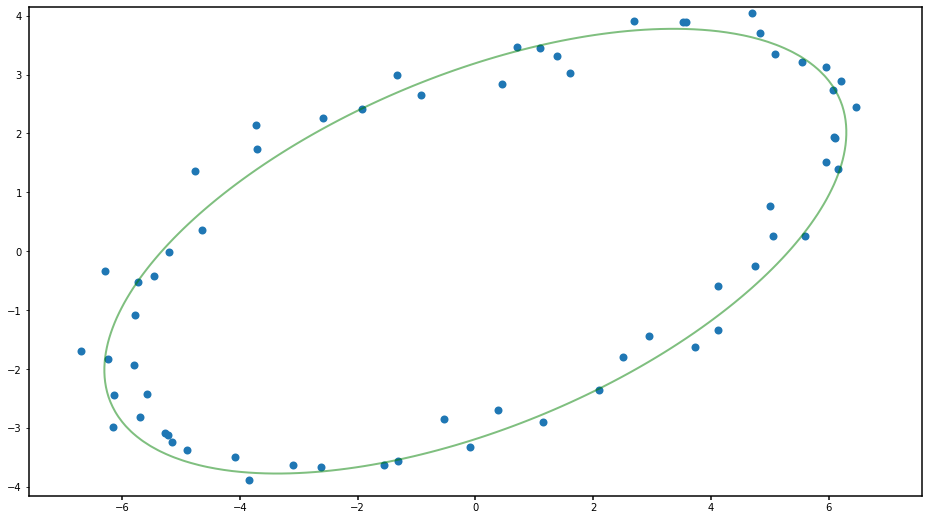

In [697]:
M = get_manisorot(theta=1*np.pi/8., a=0.2, b=1)
c = np.array([0,0])
r = 3
nb_points = 64

# Generate noisy points
std = 0.3
xs,ys = get_ellipse_contour(M,c,r, nb_points=nb_points)
xs = xs+np.random.normal(0,std,len(xs))
ys = ys+np.random.normal(0,std,len(ys))

# Draw everything
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(xs,ys)
draw_ellipse_contour(M,c,r,ax=ax,method='contour', color='g')

[ 0.03428945  0.09579669 -0.05745496]
[ 0.04230344  0.10581138 -0.07477292]


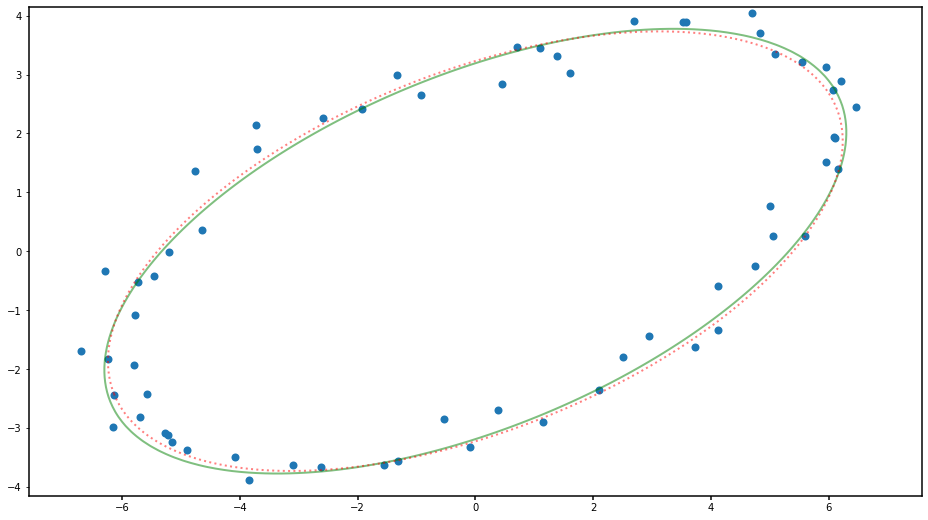

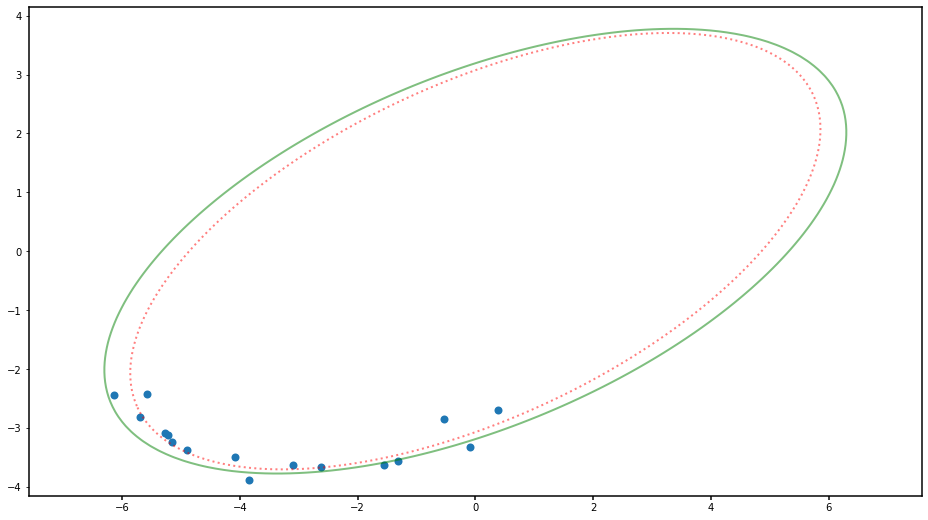

In [698]:
def get_polynomial_features(X, include_bias=False):
    """
        X has shape, (size, 2)
        returns shape (size, 2) or 3 with bias
    """
    if include_bias:
        return np.stack((X[:, 0]**2, X[:, 1]**2, X[:, 0]*X[:, 1], np.ones(X.shape[0]))).T.astype(np.float32)
    else:
        return np.stack((X[:, 0]**2, X[:, 1]**2, X[:, 0]*X[:, 1])).T.astype(np.float32)

def estimate_centered_ellipsoid(xs,ys):
    # create matrix versions of these arrays
    X = np.vstack((xs, ys)).T
    y = np.ones(X.shape[0], dtype=np.float64)
    X = get_polynomial_features(X, include_bias=False)
    solution = np.linalg.lstsq(X,y, rcond=None)[0]
    print(solution)
    Ma = solution[0]
    Md = solution[1]
    Mb = solution[2]/2
    Mc = Mb
    M_cand = np.array([[Ma, Mb],[Mc,Md]])
    c_cand = np.array([0,0])
    r_cand = 1
    return M_cand, c_cand, r_cand

# Draw full example
M_cand, c_cand, r_cand = estimate_centered_ellipsoid(xs,ys)
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(xs, ys)
draw_ellipse_contour(M,c,r,ax=ax,method='contour', color='g')
draw_ellipse_contour(M_cand,c,r_cand,ax=ax,method='parametrized', color='r')

# Draw subsampled example
xs2 = xs[:len(xs)//4]
ys2 = ys[:len(ys)//4]
M_cand, c_cand, r_cand = estimate_centered_ellipsoid(xs2,ys2)
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(xs2, ys2)
draw_ellipse_contour(M,c,r,ax=ax,method='contour', color='g')
draw_ellipse_contour(M_cand,c,r_cand,ax=ax,method='parametrized', color='r')

### Arbitrarily centered ellipsoid boudaries estimation

Lets now assume that the unknown ellipsoid can be arbitrarily centered at $c=\begin{pmatrix}c_0\\c_1\end{pmatrix}$

The equation becomes:
\begin{align*}
    (x_0, x_1-c_1) \quad \text{s.t.} \sqrt{
    \begin{pmatrix}
        x_0 - c_0\\
        x_1 - c_1
    \end{pmatrix} ^t
    \begin{pmatrix}
        M_a & M_b\\
        M_c & M_d\\
    \end{pmatrix}
    \begin{pmatrix}
        x_0 - c_0\\
        x_1 - c_1
    \end{pmatrix}} - r &= 0 \\
    \sqrt{
    \begin{pmatrix}
        x_0 - c_0\\
        x_1 - c_1
    \end{pmatrix} ^t
    \begin{pmatrix}
        M_a x_0 + M_b x_1 - M_a c_0 - M_b c_1\\
        M_c x_0 + M_d x_1 - M_c c_0 + M_d c_1\\
    \end{pmatrix}} - r &= 0 \\
      \left(M_a \right)       x_0^2 
    + \left(M_d \right)       x_1^2 
    + \left(M_b + M_c \right) x_0 x_1 
    + \left(M_a^2 \right)     c_0 c_0 
    + \left(M_d^2 \right)     c_1 c_1 
    + \left(M_b + M_c \right) c_0 c_1 
    - \left(2M_a \right)      c_0 x_0 
    - \left(2M_d \right)      c_1 x_1 
    - \left(M_b + M_c \right) c_0 x_1 
    - \left(M_b + M_c \right) c_1 x_0 
    - r^2 &= 0 \\
      \underbrace{\left(M_a \right)}{}                                      x_0^2
    + \underbrace{\left(M_d \right)}{}                                      x_1^2 
    + \underbrace{\left(M_b + M_c \right)}{}                                x_0 x_1
    + \underbrace{\left(- \left(M_b + M_c \right) c_1 - 2M_a c_0 \right)}{} x_0
    + \underbrace{\left(- \left(M_b + M_c \right) c_0 - 2M_d c_1 \right)}{} x_1
    + \underbrace{M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1}{}
    - r^2 &= 0 \\
    \end{align*}

In matrix form, that expression would read:

\begin{align*}
    \underset{{M_a, M_b, M_c, M_d, r} \in \mathbb{R}^5}{argmin} &\|
    \begin{pmatrix}
        x_{0,0}^2 & x_{1,0}^2 & x_{0,0} x_{1,0} & x_{0,0} & x_{1,0} & 1 \\
        x_{0,1}^2 & x_{1,1}^2 & x_{0,1} x_{1,1} & x_{0,1} & x_{1,1} & 1 \\
        \vdots    & \vdots    & \vdots          & \vdots  & \vdots  & \vdots \\
        x_{0,n-1}^2 & x_{1,n-1}^2 & x_{0,n-1} x_{1,n-1} & x_{0,n-1} & x_{1,n-1} & 1 \\
    \end{pmatrix}
    \begin{pmatrix}
        M_a \\
        M_d \\
        M_b + M_c \\
        - \left(M_b + M_c \right) c_1 - 2M_a c_0 \\
        - \left(M_b + M_c \right) c_0 - 2M_d c_1 \\
        M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r^2
    \end{pmatrix} \|_2^2 \\
    \Leftrightarrow
    \underset{{a, b, c, d, e, f} \in \mathbb{R}^6}{argmin} &\|M_4
    \begin{pmatrix}
        a \\ b \\ c \\ d \\ e \\ f
    \end{pmatrix}\|_2^2 
\end{align*}

There are two problems here. The first one, is that we directly see here again, that we fall back into the problem of obvious solution for the naive nullspace of matrix $M_4$. This can be solved simply by considering the eigenvector associated with the smallest non-zero and real eigenvalue of matrix $M_4$. The proof for this is pretty straightforward, and relates to the very definition of what an eigenvalue is, and make use of eigenvalue as a lagrange multiplier for the eigenvector unit constraint.
We'll get back to this point in the notebook EigenValuesAndWhereToFindThem.

Now, the second problem, that we somehow skipped in the previous point, is that, one cannot simply setup an unconstrained convex optimization problem over ${a, b, c, d, e, f} \in \mathbb{R}^6$.

The right way to formalize the actual constraint on the quadratic problem so that we make sure we end-up with a non-degenerate ellipsoid is by making sure that the discriminant of the quadratic form is positive.

Given the following matrix expression for the quadratic form we developped in the previous lines:

\begin{align*}
  \begin{pmatrix}
    a           & \frac{b}{2} & \frac{d}{2} \\
    \frac{b}{2} & c           & \frac{e}{2} \\
    \frac{d}{2} & \frac{e}{2} & f \\
  \end{pmatrix}
\end{align*}

The discriminant positivity constraints reads:

\begin{align*}
  &\Delta_{M_4} &<0& \\
  \Leftrightarrow \quad &det \begin{pmatrix}
        a           & \frac{b}{2} \\
        \frac{b}{2} & c           \\
      \end{pmatrix} &> 0 \\
  \Leftrightarrow \quad &ac - \frac{b^2}{4} &> 0
\end{align*}

It is here important to notice that there is an infinite set of solution if you scale the discriminant with any non zero positive real number, i.e by just multiplying the previous equations by arbitrary non-zero real number, you just end-up with a scaled psd matrix, and a scaled radius, but the conic is still the same.

The idea is to leverage this property by setting equality constraint: $ac - \frac{b^2}{4} = 1$
If we want to write the full problem we end-up with:

\begin{align*}
    \underset{{a, b, c, d, e, f} \in \mathbb{R}^6 \; \text{s.t} \; ac - \frac{b^2}{4} = 1 }{argmin} &\|M_4
    \begin{pmatrix}
        a \\ b \\ c \\ d \\ e \\ f
    \end{pmatrix}\|_2^2 
\end{align*}

Which is a quadratically constrained quadratic problem. 

### Quadratic constraint

Lets try to write down the quadratic constraint in matrix form. First, we need to recall that

\begin{align*}
  \begin{pmatrix}
    a \\ b \\ c \\ d \\ e \\ f
  \end{pmatrix} =
  \begin{pmatrix}
    M_a \\
    M_d \\
    M_b + M_c \\
    - \left(M_b + M_c \right) c_1 - 2M_a c_0 \\
    - \left(M_b + M_c \right) c_0 - 2M_d c_1 \\
    M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r^2
  \end{pmatrix}
\end{align*}

Now, 
\begin{align*}
  &ac - \frac{b^2}{4} &= 1 \\
  \Leftrightarrow \quad & 
  \begin{pmatrix}
    a \\ b \\ c \\ d \\ e \\ f
  \end{pmatrix}^{t}
  \begin{pmatrix}
    0 & 0 & \frac{1}{2} & 0 & 0 & 0 \\
    0 & -\frac{1}{4} & 0 & 0 & 0 & 0 \\
    \frac{1}{2} & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
  \end{pmatrix}
  \begin{pmatrix}
    a \\ b \\ c \\ d \\ e \\ f
  \end{pmatrix}
  &=1 \\
  \Leftrightarrow \quad & x D x &= 1 \\
\end{align*}

One can eventually now plug the whole system into one's favouriste solver as:
\begin{align*}
    \underset{x \in \mathbb{R}^6 \; \text{s.t} \; x^t D x = 1}{argmin} &\|M_4 x \|_2^2 
\end{align*}

#### Main aspects of the solution
We won't be going through the formal proof, but here are some elements on how to solve that problem, taken from:
Gander, W.: Least squares with a quadratic constraint. Numerische Mathematik, 36:291–307, 1981:
* The optimal point for the quadratic objectif is by definition colinear to the smallest eigenvector of $M_4$
* Using lagrange multiplier of the quadratic constraint, we can setup the following problem (TODO FIX):
\begin{align*}
    \underset{\lambda \in \mathbb{R}}{argmax} \quad \underset{x \in \mathbb{R}^6}{argmin} \quad \|M_4 x \|_2^2 + \lambda D x 
\end{align*}
The solution set should also satisfy the following constraints, as stated earlier:
\begin{align*}
x \; \text{s.t} \;
\begin{cases}
    M_4^{t}M_4 x = \lambda Dx \\
    x^{t}Dx = 1
\end{cases}
\end{align*}
The first line looks like a generalized eigenvalue problem, and if we inject those constraints in the minimization problem we get:
\begin{align*}
\|M_4 x \|_2^2 = x^{t}M_4^{t}M_4 x = \lambda x^{t} Dx = \lambda
\end{align*}
We should check for the smallest eigen value from the feasible set of solution

### From QPQC to explicit ellipse parameter extraction
Let's assume that the problem previously presented have been solved, and that we are now given with a feasible solution in $R^6$. Now we just want to put the solution into a nice format that we can plug back in to our other ellipsoid manipulation tools.

The second problem is that, even if we can find a non trivial solution in $\mathbb{R}^6$, then one needs to solve a new linear problem to disantangle $c_0$ and $c_1$. The later should actually not be to difficult to solve as we have the following mapping:
* $M_a = a$
* $M_d = b$
* $M_b = M_c = \frac{c}{2}$
* d and e can be used as 
\begin{align*}
  \begin{pmatrix}
  - 2M_a                    & - \left(M_b + M_c \right) \\
  - \left(M_b + M_c \right) & - 2M_d
  \end{pmatrix}
  \begin{pmatrix}c_0 \\ c_1 \end{pmatrix} =
  \begin{pmatrix}d \\ e \end{pmatrix} \\
  \begin{pmatrix}c_0 \\ c_1 \end{pmatrix} =
  \begin{pmatrix}
  - 2M_a                    & - \left(M_b + M_c \right) \\
  - \left(M_b + M_c \right) & - 2M_d
  \end{pmatrix}^{-1}
  \begin{pmatrix}d \\ e \end{pmatrix}
\end{align*}
* $r = \sqrt{M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 - f}$

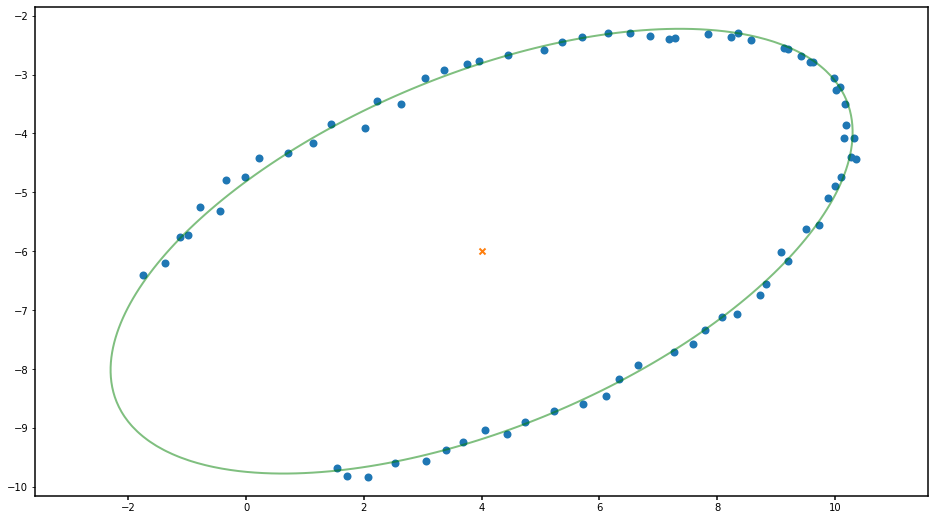

In [980]:
# Now setup the case with arbitrary center
M = get_manisorot(theta=1*np.pi/8., a=0.2, b=1)
c = np.array([4,-6])
r = 3
nb_points = 100
nb_samples = 75

# Generate noisy points
std = 0.1
xs,ys = get_ellipse_contour(M,c,r, nb_points=nb_points)
xs = xs+np.random.normal(0,std,len(xs))
ys = ys+np.random.normal(0,std,len(ys))
samples = np.random.randint(nb_points-nb_samples+1)
xs, ys = xs[samples:samples+nb_samples], ys[samples:samples+nb_samples]
# Draw everything
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(xs,ys)
ax.scatter(c[0], c[1], marker='x')
draw_ellipse_contour(M,c,r,ax=ax,method='contour', color='g')

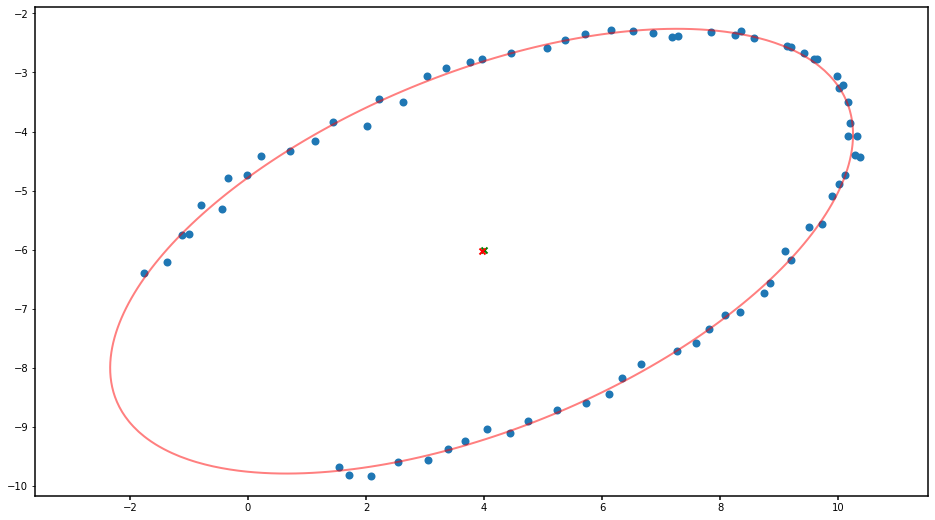

In [981]:
def get_polynomial_features_non_centered(X, include_bias=False):
    """
        X has shape, (size, 2)
        returns shape (size, 5) or 6 with bias
    """
    if include_bias:
        return np.stack((X[:, 0]**2, X[:, 1]**2, X[:, 0]*X[:, 1], X[:, 0], X[:, 1], np.ones(X.shape[0]))).T.astype(np.float32)
    else:
        return np.stack((X[:, 0]**2, X[:, 1]**2, X[:, 0]*X[:, 1], X[:, 0], X[:, 1])).T.astype(np.float32)

def get_non_centered_ellipsoid_features(xs,ys):
    # create matrix versions of these arrays
    M4 = np.vstack((xs, ys)).T
    M4 = get_polynomial_features_non_centered(M4, include_bias=True)
    return M4

def solve_qcqp(M4):
    D = np.zeros((M4.shape[1],M4.shape[1]), dtype=np.float64)
    D[1,0] = 1/2
    D[0,1] = 1/2
    D[2,2] = -1/4
    T = np.dot(M4.T, M4)
    T = np.dot(np.linalg.inv(T), D)
    w,v = np.linalg.eig(T)
    # w The eigenvalues, each repeated according to its multiplicity.
    # The eigenvalues are not necessarily ordered.
    # The resulting array will be of complex type, unless the imaginary part is zero in which case it will be
    # cast to a real type. When a is real the resulting eigenvalues will be real
    # (0 imaginary part) or occur in conjugate pairs
    # v The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding
    # to the eigenvalue w[i].    
    # find real positive eigenvalues
    
    # The solution to the unconstrained minimization problem can also work in many situations but does not
    # ensure that we end up with an ellipsoid:
    #w,v = np.linalg.eig(np.dot(M4.T,M4))
    
    pos = np.argwhere(w>0) #np.logical_and(w>0), np.isclose(np.imag(w), 0)))
    w, v = w[pos], v[:,pos]
    mini = np.argmin(w)
    w, v = w[mini], np.squeeze(np.real(v[:, mini]))
    solution = v
    prod = np.dot(v, np.dot(D,v))
    #print(f"x^t D x is {prod}")
    # Normalize so that determinant is 1 (or discriminant is -1)
    v = v/np.sqrt(prod)
    #print(f"x^t D x is {np.dot(v, np.dot(D,v))}")
    return v

def factor_quadratic(param, nb_center=1):
    """
    param is axx +byy +cxy + dx + ey +f in that order
    """
    # Ellipsoid matrix estimate
    Ma = param[0]
    Md = param[1]
    Mb = param[2]/2
    Mc = Mb
    M_cand = np.array([[Ma, Mb],[Mc,Md]])
    
    # center estimate
    csol = []
    cmat = np.array([[-2*Ma, -(Mb+Mc)],
                     [-(Mb+Mc),-2*Md]])
    for i in range(nb_center):
        cvec = param[3+2*i:5+2*i]
        csol.append(np.dot(np.linalg.inv(cmat), cvec))
    c_cand = csol
    
    # radius estimate
    r_squ = []
    for i in range(nb_center):
        csol = c_cand[i]
        r_squ.append(Ma*(csol[0]**2) + Md*(csol[1]**2) + (Mb+Mc)*csol.prod() - param[3+nb_center*2+i])
    r_squ_cand = r_squ

    if nb_center == 1:
        c_cand = c_cand[0]
        r_squ_cand = r_squ_cand[0]
    return M_cand, c_cand, r_squ_cand

def estimate_non_centered_ellipsoid(M4):
    solution = solve_qcqp(M4)
    M_cand, c_cand, r_squ = factor_quadratic(solution)

    #Performing a few tests
    assert(np.isclose(np.linalg.det(M_cand), 1))
    #_, svs, _ = np.linalg.svd(M_cand)
    #print(f"Singular values of M are {svs}")
    evs, _ = np.linalg.eig(M_cand)
    #print(f"Determinant of M {M_cand} is {np.linalg.det(M_cand)} and evs are {evs}")
    
    #We do that to turn nsd matrices into psd matrices
    s=1
    if np.any(evs<=0):
        s = -1
    M_cand = s*M_cand
    r_cand = np.sqrt(s*r_squ)

    return M_cand, c_cand, r_cand

# Draw full example
M_cand, c_cand, r_cand = estimate_non_centered_ellipsoid(get_non_centered_ellipsoid_features(xs,ys))
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(xs, ys)
ax.scatter(c[0], c[1], color='g', marker='x')
ax.scatter(c_cand[0], c_cand[1], color='r', marker='x')
#draw_ellipse_contour(M,c,r,ax=ax,method='contour', color='g')
draw_ellipse_contour(M_cand,c_cand,r_cand,fig=fig,ax=ax,method='contour', color='r')

### Thoughts about ellipsoid estimation
After we have done a few experiments with partial dataset, we realized that there is an inherent problem with this ellipsoid problem formulation.
The least square formulation we chose, by design always favor the smallest ellipsoid. Indeed, ellipsoid with largest diameter generate mean square error that are much larger in the ellipsoid centered metric. 

## Ellipsoid family from sparse set of isolevels

The idea here, is to setup almost the same problem, as seen previously, but instead of one set of points for one ellipsoid, we have multiple sets of points.

There are multiple problems one can setup, lets start with the simples one: we have one ellipsoid, but eventually multiple set of points, at different distances from the center of the ellipsoid:

\begin{align*}
    \underset{{M_a, M_b, M_c, M_d, r_0, r_1, \cdots, r_{n-1}} \in \mathbb{R}^{n+5}}{argmin} &\|
    \begin{pmatrix}
        x_{0,0}^2 & x_{1,0}^2 & x_{0,0} x_{1,0} & x_{0,0} & x_{1,0} & 1 & 0 & \cdots & 0 \\
        x_{0,1}^2 & x_{1,1}^2 & x_{0,1} x_{1,1} & x_{0,1} & x_{1,1} & 0 & 1 & \cdots & 0 \\
        \vdots    & \vdots    & \vdots          & \vdots  & \vdots  & \vdots & \vdots & \vdots & \vdots \\
        x_{0,n-1}^2 & x_{1,n-1}^2 & x_{0,n-1} x_{1,n-1} & x_{0,n-1} & x_{1,n-1} & 0 & 0 & \cdots & 1 \\
    \end{pmatrix}
    \begin{pmatrix}
        M_a \\
        M_d \\
        M_b + M_c \\
        - \left(M_b + M_c \right) c_1 - 2M_a c_0 \\
        - \left(M_b + M_c \right) c_0 - 2M_d c_1 \\
        M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r_0^2 \\
        M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r_1^2 \\
        \vdots \\
        M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r_{n-1}^2
    \end{pmatrix} \|_2^2 \\
    \Leftrightarrow
    \underset{{a, b, c, d, e, f_0, f_1, \cdots, f_{n-1}} \in \mathbb{R}^{n+5}}{argmin} &\|M_4
    \begin{pmatrix}
        a \\ b \\ c \\ d \\ e \\ f_0 \\ f_1 \\ \vdots \\ f_{n-1}
    \end{pmatrix}\|_2^2 
\end{align*}

In [456]:
#fig, ax =  plt.subplots(1,figsize=(16,9))
#calib = skimage.io.imread("./data/spectro_calib.jpg")[:,:,0]

# https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_sauvola
#thresh_prob = skimage.filters.threshold_sauvola(
#                calib, window_size=191,
#                r=12)
#thresh_prob = skimage.filters.threshold_otsu(calib)
#calib = calib > thresh_prob
#ax.imshow(calib, cmap=cm.gray)

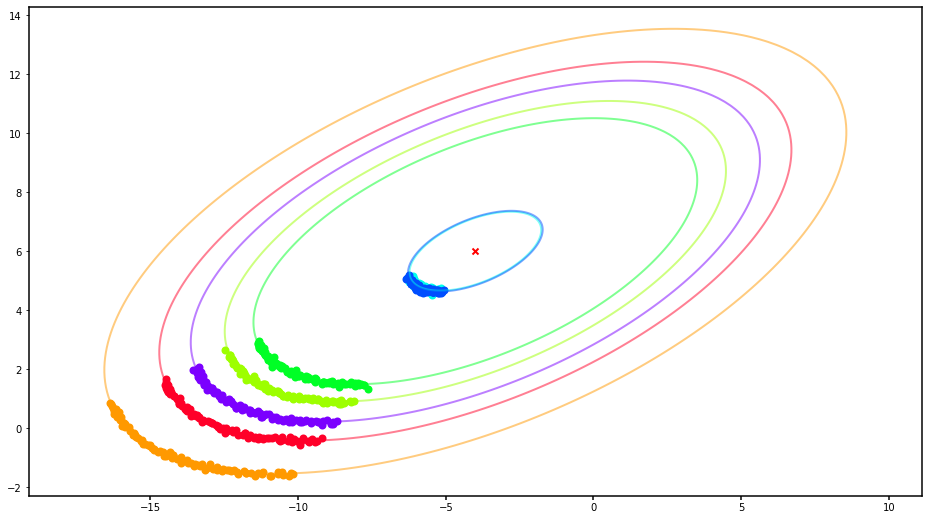

In [977]:
M = get_manisorot(theta=1*np.pi/8., a=0.2, b=1)
c = np.array([-4,6])

nb_points = 640
nb_samples = 90
nb_iso_lines = 7

# Generate noisy points
std = 0.05
rmin = 1
rmax = 6
xss = []
yss = []
rs = []

#Generate samples and draw
for i in range(nb_iso_lines):
    r = np.random.uniform(rmin, rmax)
    xs,ys = get_ellipse_contour(M,c,r, nb_points=nb_points)
    xs = xs+np.random.normal(0,std,len(xs))
    ys = ys+np.random.normal(0,std,len(ys))
    samples = 0#np.random.randint(nb_points-nb_samples+1)
    xss.append(xs[samples:samples+nb_samples])
    yss.append(ys[samples:samples+nb_samples])
    rs.append(r)

# Draw everything
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/nb_iso_lines) for i in range(nb_iso_lines)]
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(c[0],c[1], color='r', marker='x')
for xs, ys, r, color in zip(xss, yss, rs, colors):
    ax.scatter(xs,ys, color=color)
    draw_ellipse_contour(M,c,r,ax=ax,method='contour', color=color)

In [976]:
def get_polynomial_features_with_holes_same_center_diff_radii(X, nb_holes=0, index=0):
    """
        X has shape, (size, 2)
        returns shape (size, 5+nbisolevel)
        Basically first 5 features serves as common global ellipsoid curvature+center parameter estimation
        And the remaining nbisolevel parameter serves as independant radii for each isolevel
    """
    amount_before = index
    amount_after = nb_holes-1-index
    return np.stack((X[:, 0]**2,
                     X[:, 1]**2,
                     X[:, 0]*X[:, 1],
                     X[:, 0],
                     X[:, 1],
                     *([np.zeros(X.shape[0])]*amount_before),
                     np.ones(X.shape[0]),
                     *([np.zeros(X.shape[0])]*amount_after) )).T.astype(np.float32)

def estimate_non_centered_ellipsoid_isolines(M4):
    solution = solve_qcqp(M4)
    M_cand, c_cand, r_squ = factor_quadratic(solution)
    Ma = solution[0]
    Md = solution[1]
    Mb = solution[2]/2
    Mc = Mb

    #Performing a few tests
    assert(np.isclose(np.linalg.det(M_cand), 1))
    evs, _ = np.linalg.eig(M_cand)
    
    #We do that to turn nsd matrices into psd matrices
    s=1
    if np.any(evs<=0):
        s = -1
    M_cand = s*M_cand
    r_cand = [np.sqrt(s*(-Ma*(c_cand[0]**2) - Md*(c_cand[1]**2) - (Mb+Mc)*c_cand.prod() + solution[i]))
        for i in range(5,len(solution))]
    return M_cand, c_cand, r_cand

features = []
for index, (xs, ys) in enumerate(zip(xss, yss)):
    M4 = np.vstack((xs, ys)).T
    M4 = get_polynomial_features_with_holes_same_center_diff_radii(M4, nb_holes=len(xss), index=index)
    features.append(M4)

# Now perform global optimization
M4 = np.concatenate(tuple(features), axis=0)
M_cand, c_cand, r_cand = estimate_non_centered_ellipsoid_isolines(M4)

# Draw results
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/nb_iso_lines) for i in range(nb_iso_lines)]
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(c_cand[0], c_cand[1], color='r', marker='x')
for xs, ys, r, color in zip(xss, yss, r_cand, colors):
    ax.scatter(xs,ys, color=color)
    draw_ellipse_contour(M_cand,c_cand,r, ax=ax,method='contour', color=color)

RuntimeWarning: invalid value encountered in sqrt

### Iterative reweighting version
Eventually we realized that ellipsoid estimation, are by design giving much lower cost for points closer to  center of the ellipse.
We are here trying an iterative reweighted least square to try to mitigate this problem.
The weight we decided to choose (arbitrarily) is the inverse of the distance between ellipse center and set of points isolevel expressed within the ellipsoid matrix based distance. This is not however going to fix the problem of squared errors between points and isolevels, that expressed in the ellipsoid based distance, yield much higher constraints on the points far away from the center than on the points closeby it.

At each step we now solve

\begin{align*}
    \underset{{M_a, M_b, M_c, M_d, r_0, r_1, \cdots, r_{n-1}} \in \mathbb{R}^{n+5}}{argmin} &\|
    \begin{pmatrix}
        \frac{1}{r_{0}^{k-1}} & 0 & \cdots & 0 \\
        0 & \frac{1}{r_{1}^{k-1}} & \cdots & 0 \\
        \vdots & \ddots & \ddots & \vdots \\
        0 & 0 & \cdots & \frac{1}{r_{n-1}^{k-1}} \\
    \end{pmatrix}
    \begin{pmatrix}
        x_{0,0}^2 & x_{1,0}^2 & x_{0,0} x_{1,0} & x_{0,0} & x_{1,0} & 1 & 0 & \cdots & 0 \\
        x_{0,1}^2 & x_{1,1}^2 & x_{0,1} x_{1,1} & x_{0,1} & x_{1,1} & 0 & 1 & \cdots & 0 \\
        \vdots    & \vdots    & \vdots          & \vdots  & \vdots  & \vdots & \vdots & \vdots & \vdots \\
        x_{0,n-1}^2 & x_{1,n-1}^2 & x_{0,n-1} x_{1,n-1} & x_{0,n-1} & x_{1,n-1} & 0 & 0 & \cdots & 1 \\
    \end{pmatrix}
    \begin{pmatrix}
        M_a \\
        M_d \\
        M_b + M_c \\
        - \left(M_b + M_c \right) c_1 - 2M_a c_0 \\
        - \left(M_b + M_c \right) c_0 - 2M_d c_1 \\
        M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r_0^2 \\
        M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r_1^2 \\
        \vdots \\
        M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1 -r_{n-1}^2
    \end{pmatrix} \|_2^2 \\
    \Leftrightarrow
    \underset{{a, b, c, d, e, f_0, f_1, \cdots, f_{n-1}} \in \mathbb{R}^{n+5}}{argmin} &\|W^{k} M_4
    \begin{pmatrix}
        a \\ b \\ c \\ d \\ e \\ f_0 \\ f_1 \\ \vdots \\ f_{n-1}
    \end{pmatrix}\|_2^2 
\end{align*}

Where $W^{k}$ is updated at each step so that points closer to the ellipse center are reweighted accordingly

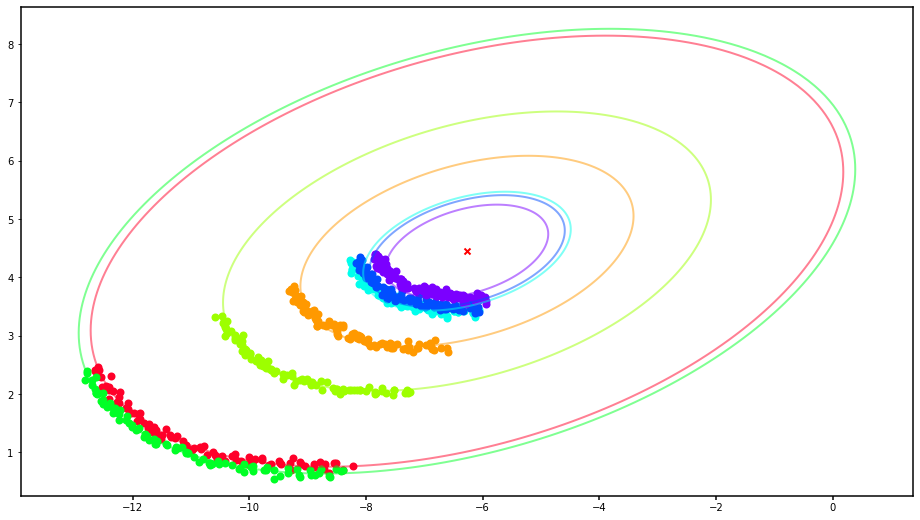

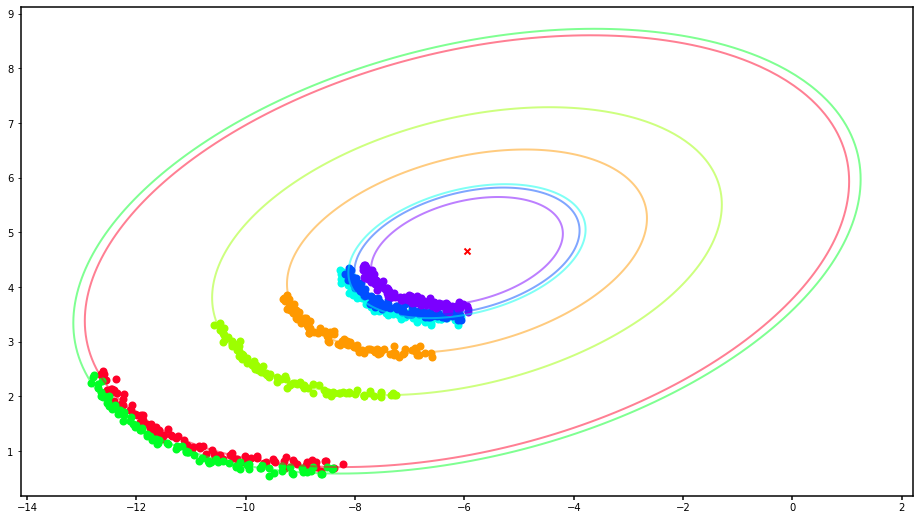

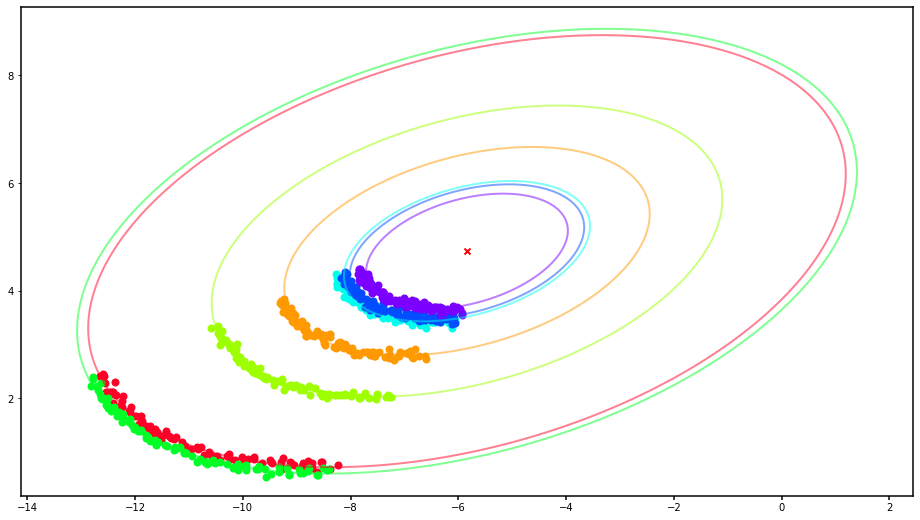

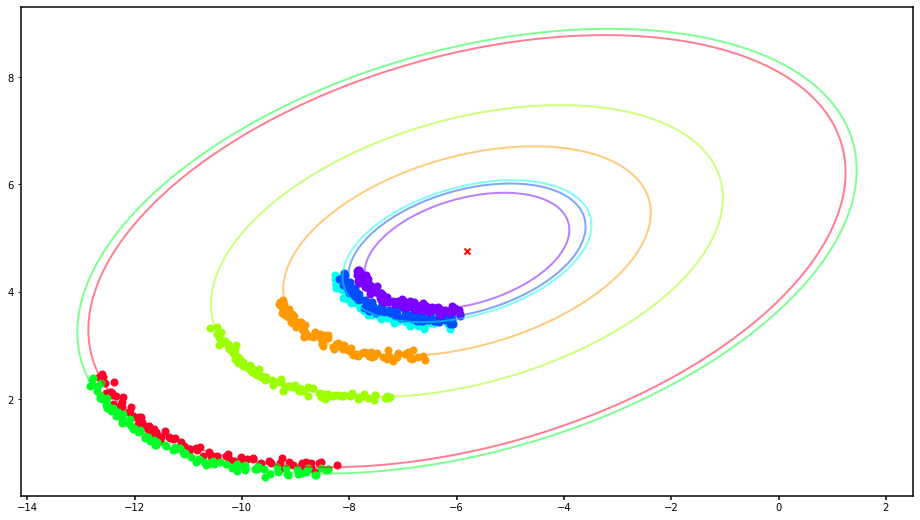

In [970]:
weights = np.ones(len(xss))
for iter in range(4):
    features = []
    # Now reweight if needed
    for index, (xs, ys) in enumerate(zip(xss, yss)):
        M4 = np.vstack((xs, ys)).T
        M4 = weights[index]*get_polynomial_features_with_holes_same_center_diff_radii(M4, nb_holes=len(xss), index=index)
        features.append(M4)
    # Now perform global optimization
    M4 = np.concatenate(tuple(features), axis=0)
    M_cand, c_cand, r_cand = estimate_non_centered_ellipsoid_isolines(M4)
    # Update weights
    weights = 1/np.array(r_cand)
    # Show results
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/nb_iso_lines) for i in range(nb_iso_lines)]
    fig, ax = plt.subplots(1,figsize=(16,9))
    ax.scatter(c_cand[0], c_cand[1], color='r', marker='x')
    for xs, ys, r, color in zip(xss, yss, r_cand, colors):
        ax.scatter(xs,ys, color=color)
        draw_ellipse_contour(M_cand,c_cand,r, ax=ax,method='contour', color=color)

### Sparse set of isolevels with ellipsoid matrix part in common

In [ ]:
def get_polynomial_features_with_holes_diff_radius_diff_center(X, nb_holes=0, index=0):
    """
        X has shape, (size, 2)
        returns shape (size, 3+3xnbisolevel)
        Basically first 3 features serves as common global ellipsoid curvature parameter estimation
        And the remaining 3xnbisolevel parameter serves as independant parameters for the independant center
        and radii parameters
    """
    amount_before = index
    amount_after = nb_holes-1-index
    return np.stack((X[:, 0]**2,
                     X[:, 0]*X[:, 1],
                     X[:, 1]**2,
                     *([np.zeros(X.shape[0])]*2*amount_before),
                     X[:, 0],
                     X[:, 1],
                     *([np.zeros(X.shape[0])]*2*amount_after),
                     *([np.zeros(X.shape[0])]*amount_before),
                     -np.ones(X.shape[0]),
                     *([np.zeros(X.shape[0])]*amount_after) )).T.astype(np.float64)

def estimate_non_centered_ellipsoid_isolines_with centers(M4, nb_isolines):
    solution = solve_qcqp(M4)
    M_cand, c_cand, r_squ_cand = factor_quadratic(solution, nb_center=nb_isolines)
    Ma = solution[0]
    Md = solution[1]
    Mb = solution[2]/2
    Mc = Mb

    #Performing a few tests
    assert(np.isclose(np.linalg.det(M_cand), 1))
    evs, _ = np.linalg.eig(M_cand)
    
    #We do that to turn nsd matrices into psd matrices
    if np.any(evs<=0):
        s = -1
    M_cand = s*M_cand
    r_cand = [np.sqrt(-Ma*(c_cand[0]**2) - Md*(c_cand[1]**2) - (Mb+Mc)*c_cand.prod() + solution[i])
        for i in range(5,len(solution))]


    return M_cand, c_cand, r_cand

features = []
for index, (xs, ys) in enumerate(zip(xss, yss)):
    M4 = np.vstack((xs, ys)).T
    M4 = get_polynomial_features_with_holes_diff_radius_diff_center(M4, nb_holes=len(xss), index=index)
    features.append(M4)

# Now perform global optimization
M4 = np.concatenate(tuple(features), axis=0)
M_cand, c_cand, r_cand = estimate_non_centered_ellipsoid_isolines_with(M4,nb_isolines=len(xss))

# Draw results
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/nb_iso_lines) for i in range(nb_iso_lines)]
fig, ax = plt.subplots(1,figsize=(16,9))
ax.scatter(c_cand[0], c_cand[1], color='r', marker='x')
for xs, ys, r, color in zip(xss, yss, r_cand, colors):
    ax.scatter(xs,ys, color=color)
    draw_ellipse_contour(M_cand,c_cand,r, ax=ax,method='contour', color=color)

### Multivariate gaussian distribution and soft ellipsoid

#### One dimensional case

The moment estimate method is very well known in statistic, to perform statistical distribution parameter estimation. And of course, in many complex process, or large scale problems, central-limit theorem tells us that sums of probability distribution tends to the normal law:

$$
    pdf(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

This is why one dimensional gaussian distribution parameter distribution is easily performed every day, using order 1 estimator (mean) for $k$ discrete sample data points:
$$
    \bar{x} = \sum_{i=0}^{k-1} \frac{1}{k} x_i
$$

Although there is always a debate between biased and unbiased estimator of the variance (order 2 moment) of a discrete distribution, we choose the biased one $v$, because of its behaviour when a few samples are availables:
$$
    v = \sum_{i=0}^{k-1} \frac{1}{k} (x_i-\bar{x})^2
$$

#### Multi-dimensional case

The normal distribution can pleasantly be extended to the n-dimensional case as follows:
$$
    pdf(x) = \frac{1}{\sqrt{(2\pi)^n det(\Sigma)}} e^{-\frac{1}{2} (x-\mu)^{\intercal}\Sigma^{-1}(x-\mu)}
$$
Where of course, $\Sigma$, the covariance matrix, is PSD. It is interesting to notice that the term $(x-\mu)^{\intercal}\Sigma^{-1}(x-\mu)$ is equivalent to the square of the Mahalanobis distance.

The intuition behind this scheme is that, when sampled from a random experiment, the variables, (or the linear combination of variables that defines a direction) that tends to have a high variability will have strong coefficients in the diagonalized version of the covariance matrice.

As seen earlier, the semi axis of the ellipsoid in a given direction will be equal to the inverse of the squared root of the diagonal term in the corresponding position in the diagonalized matrix.
This is why strong coefficient in the covariance matrix will generate weak coefficients in the inverse covariance matrix, hence large semi axis in the geometrical ellipsoid.

(-5.0, 10.0, -2.0, 6.0)

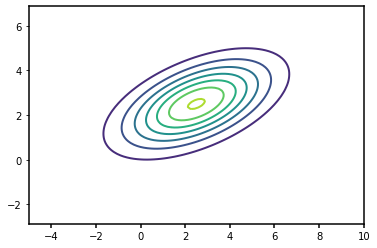

In [408]:
#Here is an example of a 2D gaussian distribution

#Generate predefined meshgrid
x = np.linspace(-5, 10, 100)
y = np.linspace(-2, 6, 100)
X, Y = np.meshgrid(x,y)
xvec = np.array([np.reshape(X,X.size),np.reshape(Y,Y.size)])

Sigma = la.inv(Manisorot)
mu = np.array([2.5,2.5]).reshape(2,1)
coef = 1/np.sqrt(np.power(2*np.pi,2)*la.det(Sigma))

#plot contour of 2-dimensional gaussian pdf
test=np.dot(la.inv(Sigma),xvec-mu)
Egauss=coef * np.exp(-0.5* np.sum(test*(xvec-mu),0))

plt.contour(X,Y,np.reshape(Egauss,X.shape))
plt.axis('equal')

### Estimating one or muliple multidimensional gaussian distribution parameters

The moment estimatation method we talked about previously can easily be used to estimate the parameters $\mu,\Sigma$ of a gaussian distribution.

We just have to define it for $k$ sample $x_i \in \mathbb{R}^n$ points in a n-dimensional world:
$$
    \mu = \sum_{i=0}^{k-1} \frac{1}{k} x_i
$$

And the covariance matrix $\Sigma$ is estimated from $X$, the matrix whose $i^{th}$ column is $x_i-\mu$
$$
    \Sigma = \frac{1}{k} X X^{\intercal}
$$

It can be proved that this moment estimate method gives the maximum likelihood solution of the parameters given the dataset.

(2, 150)
(2, 2)


(-5.0, 10.0, -2.0, 6.0)

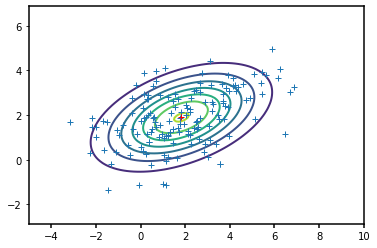

In [406]:
#Here is an example of a 2D gaussian distribution
k = 150
X = np.random.multivariate_normal([2,2],Sigma,k).T
plt.plot(X[0,:],X[1,:], '+')

#Estimate mu
muEst = (X.sum(1)/k).reshape(2,1)
plt.plot(muEst[0],muEst[1], 'r+')

#Estimate Sigma
Xcent=X-muEst
print(Xcent.shape)
SigmaEst = np.dot(Xcent,Xcent.T)/k
print(SigmaEst.shape)

#Generate predefined meshgrid
x = np.linspace(-5, 10, 100)
y = np.linspace(-2, 6, 100)
Xax, Yax = np.meshgrid(x,y)
xvec = np.array([np.reshape(Xax,Xax.size),np.reshape(Yax,Yax.size)])

#plot contour of 2-dimensional gaussian pdf
coef = 1/np.sqrt(np.power(2*np.pi,2)*la.det(SigmaEst))
test=np.dot(la.inv(SigmaEst),xvec-muEst)
EgaussEst=coef * np.exp(-0.5* np.sum(test*(xvec-muEst),0))

plt.contour(Xax,Yax,np.reshape(EgaussEst,Xax.shape))
plt.axis('equal')

## Quadratic and linear discriminant analysis

Although the topic we are going to cover here is not really related to geometry, 

### QDA for two classes

A large part of this chapter is inspired by or a direct copy of the the [wikipedia article](https://en.wikipedia.org/wiki/Linear_discriminant_analysis).

Consider a set of observations $\vec{x}$ (also called features, attributes, variables or measurements) for each sample of an object or event with known class $y$. This set of samples is called the training set. The classification problem is then to find a good predictor for the class $y$ of any sample of the same distribution (not necessarily from the training set) given only an observation $\vec {x}$

LDA approaches the problem by assuming that the conditional probability density functions $P(\vec {x}|y=0)$ and $P(\vec{x}|y=1)$ are both normally distributed with mean and covariance parameters $\left(\vec{\mu}_{0},\Sigma _{0}\right)$ and $\left(\vec{\mu }_{1},\Sigma _{1}\right)$ respectively. Under this assumption, the Bayes optimal solution is to predict points as being from the first class if the log of the likelihood ratios is bigger than some threshold T.

The ratio writes:

\begin{align*}
    \text{ratio} &= \frac{P(\vec{x}|y=0)}{P(\vec{x}|y=1)} \\
    &= \frac{\frac{1}{\sqrt{(2\pi)^n det(\Sigma_0)}} e^{-\frac{1}{2} (x-\mu_0)^{\intercal}\Sigma_0^{-1}(x-\mu_0)}}{\frac{1}{\sqrt{(2\pi)^n det(\Sigma_1)}} e^{-\frac{1}{2} (x-\mu_1)^{\intercal}\Sigma_1^{-1}(x-\mu_1)}}
\end{align*}

The threshold on the logarithm of this ratio then writes:

\begin{align*}
    & log \left( \frac{P(\vec{x}|y=0)}{P(\vec{x}|y=1)} \right) > T \\
    &\Leftrightarrow log(P(\vec{x}|y=0))-log(P(\vec{x}|y=1)) > T \\
    &\Leftrightarrow -\frac{n}{2}log(2\pi) -\frac{1}{2}log(det(\Sigma_0)) -\frac{1}{2} (x-\mu_0)^{\intercal}\Sigma_0^{-1}(x-\mu_0) + \frac{n}{2} log(2\pi) + \frac{1}{2}log(det(\Sigma_1)) + \frac{1}{2} (x-\mu_1)^{\intercal}\Sigma_1^{-1}(x-\mu_1) > T \\
    &\Leftrightarrow \frac{1}{2} \left( log(det(\Sigma_1))-log(det(\Sigma_0))) + (x-\mu_1)^{\intercal}\Sigma_1^{-1}(x-\mu_1) -(x-\mu_0)^{\intercal}\Sigma_0^{-1}(x-\mu_0) \right) > T
\end{align*}

Without any further assumptions, the resulting classifier is referred to as QDA (quadratic discriminant analysis).

### Homoscedasticity and LDA

LDA instead makes the additional simplifying homoscedasticity assumption (i.e. that the class covariances are identical, so $\Sigma _{0} = \Sigma _{1} = \Sigma$) and that the covariances have full rank. In this case, several terms cancel thank to the following equality (we use hermitian property of $\Sigma^{-1}$):

\begin{align*}
    & (x-\mu)^{\intercal}\Sigma^{-1}(x-\mu) \\
    =& (x-\mu)^{\intercal}\Sigma^{-1}(x) -(x-\mu)^{\intercal}\Sigma^{-1}(\mu) \\
    =& (x)^{\intercal}\Sigma^{-1}(x) -(\mu)^{\intercal}\Sigma^{-1}(x) -(x)^{\intercal}\Sigma^{-1}(\mu) +(\mu)^{\intercal}\Sigma^{-1}(\mu) \\
    =& (x)^{\intercal}\Sigma^{-1}(x) + (\mu)^{\intercal}\Sigma^{-1}(\mu) -2(x)^{\intercal}\Sigma^{-1}(\mu)
\end{align*}

we have
\begin{align*}
    & (x-\mu_1)^{\intercal}\Sigma_1^{-1}(x-\mu_1) -(x-\mu_0)^{\intercal}\Sigma_0^{-1}(x-\mu_0) > 2T \\
    \Leftrightarrow& (\mu_1)^{\intercal}\Sigma^{-1}(\mu_1) -(\mu_0)^{\intercal}\Sigma^{-1}(\mu_0) -2(x)^{\intercal}\Sigma^{-1}(\mu_0-\mu_1) > 2T \\
     \Leftrightarrow&  -2(x)^{\intercal}\Sigma^{-1}(\mu_0-\mu_1) > 2T - (\mu_1)^{\intercal}\Sigma^{-1}(\mu_1) -(\mu_0)^{\intercal}\Sigma^{-1}(\mu_0) \\
     \Leftrightarrow& \left(\Sigma^{-1}(\mu_0-\mu_1)\right)^{\intercal}(x) > T - \frac{1}{2} \left((\mu_1)^{\intercal}\Sigma^{-1}(\mu_1) -(\mu_0)^{\intercal}\Sigma^{-1}(\mu_0) \right) \\
     \Leftrightarrow& w \cdot x > c
\end{align*}

Which amount to a simple linear model where we can identify
* $w = \left(\Sigma^{-1}(\mu_0-\mu_1)\right)^{\intercal}$
* $c = T - \frac{1}{2} \left((\mu_1)^{\intercal}\Sigma^{-1}(\mu_1) -(\mu_0)^{\intercal}\Sigma^{-1}(\mu_0) \right)$

This means that the criterion of an input $x$ being in a class $y$ is purely a function of this linear combination of the known observations.

It is often useful to see this conclusion in geometrical terms: the criterion of an input $\vec{x}$ being in a class $y$ is purely a function of projection of multidimensional-space point {$\vec{x}$ onto vector $\vec{w}$ (thus, we only consider its direction). In other words, the observation belongs to $y$ if corresponding $\vec{x}$ is located on a certain side of a hyperplane perpendicular to $\vec{w}$. The location of the plane is defined by the threshold $c$.

## Estimate centroids and FWHM for astronomical imaging

As a simple example of usefulness of ellipsoid estimation, we are going to use the previous example on an astronomical usecase: the dataset stands for a 2d diffraction image of a star discretized over a 2d regular grid of pixels.

We gave a full example of this usecase inside the SpatiallyVariantDeconvolution notebook

### Multiple gaussian distribution and the EM algorithm

It is interesting to know that, we can extended this moment estimate method to multiple distribution estimation in order to perform "smooth clustering".

This is actually the most simple instance of the expectation maximization algorithm, previously seen in the InformationTheoryOptimization notebook.

Here, the expectation step consist in applying our moment estimate method independantly over each cluster of data.
Then the maximization part amounts to assign our sample to the distribution that maximizes its own probability.

This variant of the k-mean algorithm unfortunately suffer from the very same drawback, it is extremly sensitive to initialization, and balance in the size of the cluster.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


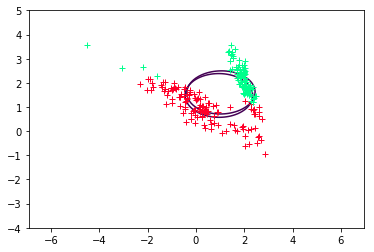

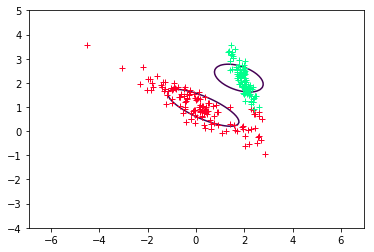

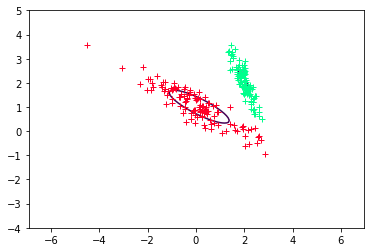

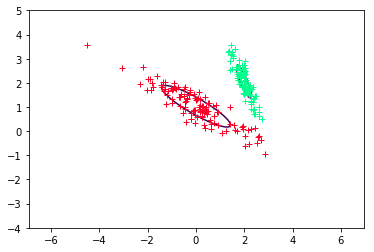

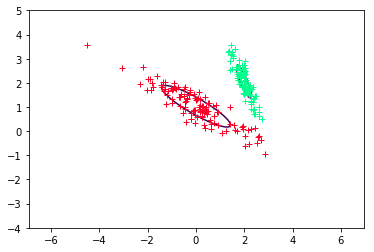

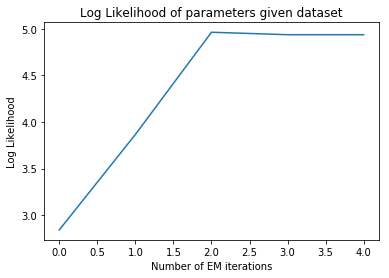

In [16]:
import random as rnd

#Let's try this EM instance
Sigma1 = np.dot(GetRotMat(np.pi/8),np.dot(np.diag([0.02,0.5]),GetRotMat(np.pi/8).T))
Sigma2 = np.dot(GetRotMat(np.pi/3),np.dot(np.diag([0.08,2]),GetRotMat(np.pi/3).T))

#generate 2 random instances
k = 250
# 2d distribution = rnd(mean,covariance,nbSamples)
X = np.random.multivariate_normal([2,2],Sigma1,(k+1)//2)
Y = np.random.multivariate_normal([0,1],Sigma2,k//2)
X=np.concatenate((X,Y),axis=0)
np.random.shuffle(X)
X=X.T

#Generate predefined meshgrid
minAx=-4
maxAx=5
x = np.linspace(minAx, maxAx, 100)
y = np.linspace(minAx, maxAx, 100)
Xax, Yax = np.meshgrid(x,y)
xvec = np.array([np.reshape(Xax,Xax.size),np.reshape(Yax,Yax.size)])

#Now Initialize n clusters, here n=2
nclusters=2
clusters = []
for i in range(nclusters):
    clusters.append({})
belonging = np.random.randint(0,nclusters,k)
likeMap = np.zeros((k,nclusters))

#EM algorithm
nb_iter = 5
loglikelihood = []

for iter in range(nb_iter):
    #Expectation
    for i in range(nclusters):
        belongs = belonging==i
        #print "belongs for cluster "+str(i)+" = "+str(belongs)
        ki=np.count_nonzero(belongs)
        Xi = X[:,belongs]
        mu = (Xi.sum(1)/ki).reshape(2,1)
        clusters[i]['mu'] = mu
        XiCent = Xi-mu
        clusters[i]['Sigma'] = np.dot(XiCent,XiCent.T)/ki

    #Maximization
    for idx,cl in enumerate(clusters):
        coef = 1/np.sqrt(np.power(2*np.pi,2)*la.det(cl['Sigma']))
        test=np.dot(la.inv(cl['Sigma']),X-cl['mu'])
        likeMap[:,idx]=coef * np.exp(-0.5* np.sum(test*(X-cl['mu']),0))
        belonging=np.argmax(likeMap,1)
    
    #total likelihood
    loglikelihood.append(np.log(likeMap[range(len(belonging)),belonging].sum()))
    
    #Check that no cluster stole all the elements
    for idx,cl in enumerate(clusters):
        minNbElem = np.maximum(2,k/(nclusters*3))
        if np.count_nonzero(belonging==idx)<minNbElem:
            print("Clustering restart, because population went under "+\
                str(100./(nclusters*3.))+"% of the dataset")
            #Steal the farthest point in the biggest cluster
            bigClIdx = np.bincount(belonging).argmax()
            belonging[ likeMap[:,bigClIdx].argsort()[:minNbElem]]=idx

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/len(clusters)) for i in range(len(clusters))]

    #plot clustering results
    for idx,cl in enumerate(clusters):
        belongs = belonging==idx

        plt.figure(iter)
        #plot points with specific color
        plt.plot(X[0,belongs],X[1,belongs], '+', color=colors[idx])

        #plot contour
        sig = cl['Sigma']
        mu = cl['mu']
        coef = 1/np.sqrt(np.power(2*np.pi,2)*la.det(sig))
        test=np.dot(la.inv(sig),xvec-mu)
        Ei=coef * np.exp(-0.5* np.sum(test*(xvec-mu),0))
        plt.contour(Xax,Yax,np.reshape(Ei,Xax.shape),1,color=colors[idx])
        plt.axis('equal')

plt.figure(iter+1)
plt.title( "Log Likelihood of parameters given dataset")
plt.xlabel('Number of EM iterations')
plt.ylabel('Log Likelihood')
plt.plot(range(nb_iter),loglikelihood)

## Other possible generalization: spectrahedron


### n-ellipse
Another possible generalization of ellipse, that is based, not on positive semidefinite matrix, defining axis dependant distance, is to add more points, ie more foci, and vizualize the resulting "isodistance" lines.

An example of such construct in 2 dimensional space is called the n-ellipse: (source of the followin informations: https://en.wikipedia.org/wiki/N-ellipse)


### Spectrahedron

(Source for this article can be found there: (https://en.wikipedia.org/wiki/Spectrahedron)